In [1]:
from util import *
from glob import glob

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = load_AOIs()
df

,Taranaki,AOI,SSP 4.5 (p50),SSP 4.5 (p83),SSP 8.5 (p50),SSP 8.5 (p83),Rate SSP 4.5 (p50),Rate SSP 4.5 (p83),Rate SSP 8.5 (p50),Rate SSP 8.5 (p83),match,match_score
7,NORTH,TongaporutuRiver,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,TongapurutuRiverCliffs,93.750000
11,SOUTH,HangatahuaRiver_South,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,HangatahuRiver_South,97.435897
21,SOUTH,Rahotu,0.58,0.78,0.84,1.10,0.0058,0.0078,0.0084,0.0110,Rahotu,100.000000
20,SOUTH,Pihama,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,Pihama,100.000000
19,SOUTH,OpunakeBeach,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,OpunakeBeachCliffs,100.000000
18,SOUTH,OhaweBeach,0.57,0.78,0.83,1.10,0.0057,0.0078,0.0083,0.0110,OhaweBeach,100.000000
17,SOUTH,Oeo,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,Oeo,100.000000
16,SOUTH,Manutahi,0.57,0.78,0.83,1.10,0.0057,0.0078,0.0083,0.0110,Manutahi,100.000000
15,SOUTH,ManaBay,0.57,0.78,0.83,1.10,0.0057,0.0078,0.0083,0.0110,ManaBayCliffs,100.000000
14,SOUTH,KaupokonuiBeach,0.57,0.78,0.84,1.10,0.0057,0.0078,0.0084,0.0110,KaupokonuiBeach,100.000000


In [3]:
all_results = []
for site in tqdm(df.match):
  gdf = gpd.read_file(f"Shapefiles/{site}_intersects.shp")
  gdf.crs = 2193
  gdf = enrich_df(gdf)
  transect_metadata = get_transect_metadata(f"Shapefiles/{site}_TransectLines.shp")
  if site == "ManaBayCliffs":
    print("Flipping")
    for k, v in transect_metadata.items():
      transect_metadata[k]["Azimuth"] = v["Azimuth"] + 180
  linear_models = fit(gdf, transect_metadata)
  linear_models.loc[linear_models.slope > 0, "slope"] = pd.NA
  rolled_slopes = linear_models.groupby("group").slope.rolling(10, min_periods=1).mean().dropna().reset_index(level=0)
  linear_models.slope = rolled_slopes.slope
  linear_models.dropna(inplace=True)
  linear_models.index = linear_models.TransectID
  # Find the closest data point to 2000
  gdf["years_since_2000"] = (gdf.Year - 2000).abs()
  closest_to_2000 = gdf.loc[gdf.groupby("TransectID").years_since_2000.idxmin()]
  closest_to_2000.set_index("TransectID", inplace=True)
  # Predict to the closest year to 2000
  linear_models["FUTURE_YEAR"] = closest_to_2000.Year
  results = predict(gdf, linear_models, transect_metadata)
  results.index = results.TransectID.astype(int)
  results["True"] = closest_to_2000.geometry
  all_results.append(results)

  0%|          | 0/24 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflo

Flipping


/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/usr/local/lib/python3.8/dist-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/home/nyou045/.local/lib/python3.8/site-packages/sklearn/metrics/_regression.py:918: Und

In [4]:
all_results = pd.concat(all_results)
all_results

,TransectID,slope,intercept,group,r2_score,mae,mse,rmse,FUTURE_YEAR,BaselineID,...,ocean_point,linear_model_point,linear_model_distance,sqrt_model_point,sqrt_model_distance,BH_model_point,BH_model_distance,Sunamura_model_point,Sunamura_model_distance,True
TransectID,,,,,,,,,,,,,,,,,,,,,
2,2.0,-0.065018,17.628984,0.0,0.658856,0.770637,0.909138,0.953487,2011.0,1,...,POINT (1734901.294958501 5698259.049972313),POINT (1735114.055735204 5697806.2951233275),0.254037,POINT (1735116.482537082 5697801.130889888),5.960058,POINT (1735120.7613459069 5697792.025586394),16.020612,POINT (1735116.1250134942 5697801.891699942),5.119430,POINT (1735113.825 5697806.787)
3,3.0,-0.142436,28.436840,0.0,0.700458,3.301923,18.667049,4.320538,2011.0,1,...,POINT (1734897.1336462596 5698251.896706724),POINT (1735121.2748274847 5697811.234611702),-5.609111,POINT (1735126.9420696187 5697800.092800197),6.891193,POINT (1735128.422893738 5697797.181496459),10.157464,POINT (1735123.4785610542 5697806.902066266),-0.748309,POINT (1735123.435 5697806.987)
4,4.0,-0.151714,24.779193,0.0,0.753700,2.267037,8.555992,2.925063,2011.0,1,...,POINT (1734900.895041738 5698249.22434408),POINT (1735132.9042014643 5697808.620776326),-2.044426,POINT (1735139.1077513464 5697796.839749171),11.270102,POINT (1735140.2502180436 5697794.670115423),13.722150,POINT (1735135.1687063214 5697804.3203042215),2.815826,POINT (1735133.042 5697808.360)
5,5.0,-0.149376,22.298158,0.0,0.845235,1.385853,3.351248,1.830641,2011.0,1,...,POINT (1734907.5357417199 5698248.764666272),POINT (1735143.546654849 5697809.159026729),-1.046826,POINT (1735149.7475224163 5697797.608983061),12.062493,POINT (1735151.0044365593 5697795.267792401),14.719749,POINT (1735145.845678354 5697804.876751453),3.813564,POINT (1735142.651 5697810.828)
6,6.0,-0.146611,22.375056,0.0,0.904625,1.120413,1.749561,1.322710,2011.0,1,...,POINT (1734912.0278775676 5698248.993504751),POINT (1735152.9020968357 5697812.110104955),-1.113746,POINT (1735159.1144658017 5697800.8424778795),11.752992,POINT (1735160.514576642 5697798.30303972),14.652829,POINT (1735155.2488885478 5697807.853633071),3.746808,POINT (1735151.779 5697814.147)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,935.0,-0.243945,37.645297,54.0,0.893162,1.562624,3.928386,1.982016,2017.0,1,...,POINT (1737816.576170825 5589951.845946035),POINT (1737753.1579577175 5590450.353831901),2.525603,POINT (1737750.2278716404 5590473.386190338),25.743591,POINT (1737751.000086336 5590467.316086871),19.624565,POINT (1737752.4935145443 5590455.576781986),7.790648,POINT (1737753.678 5590446.268)
937,937.0,-0.229478,16.470173,54.0,0.919712,1.036512,1.577046,1.255805,2017.0,1,...,POINT (1737912.846216573 5589977.436519714),POINT (1737757.9367203978 5590458.192832504),5.097599,POINT (1737751.2382318573 5590478.981362139),26.938677,POINT (1737752.6926020337 5590474.467774136),22.196561,POINT (1737756.321686947 5590463.205033473),10.363574,POINT (1737760.122 5590451.411)
938,938.0,-0.214746,12.752737,54.0,0.481127,1.909478,6.367790,2.523448,2017.0,1,...,POINT (1737913.1251714577 5589978.289947391),POINT (1737765.2494015049 5590466.53784703),10.150228,POINT (1737759.3248150887 5590486.099313218),30.589202,POINT (1737760.2929748714 5590482.902697704),27.249190,POINT (1737763.7226939425 5590471.578644187),15.417150,POINT (1737768.552 5590455.633)


In [5]:
for model in SUPPORTED_MODELS:
  all_results[f"{model}_model_error"] = gpd.GeoSeries(all_results[f"{model}_model_point"], crs=2193).distance(all_results["True"])

In [6]:
all_results[["linear_model_error", "sqrt_model_error", "BH_model_error", "Sunamura_model_error"]].describe()

,linear_model_error,sqrt_model_error,BH_model_error,Sunamura_model_error
count,16090.000000,16090.000000,16090.000000,16090.000000
mean,5.225654,20.095744,17.066711,7.585884
std,6.289969,22.389261,7.619461,6.520794
min,0.000181,0.008917,0.003291,0.000478
25%,1.323460,5.130125,13.267959,3.701996
50%,3.245376,12.046586,16.816602,6.081661
75%,6.892127,26.288259,20.188231,9.556913
max,114.836160,241.480949,130.602736,119.619823


<AxesSubplot:>

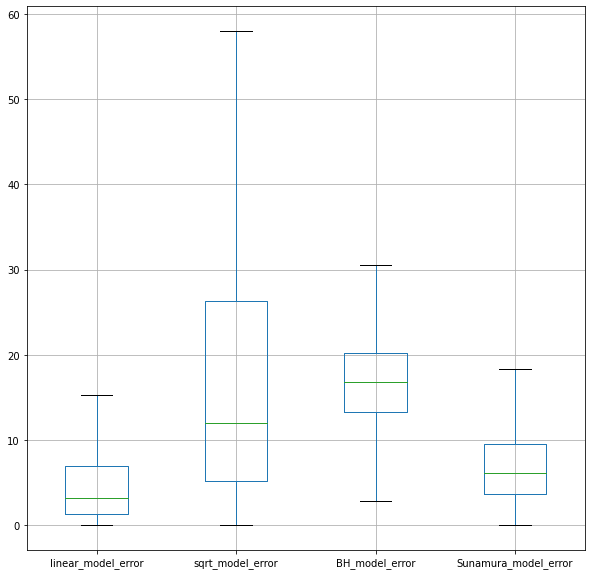

In [7]:
all_results[["linear_model_error", "sqrt_model_error", "BH_model_error", "Sunamura_model_error"]].boxplot(figsize=(10,10), showfliers=False)